# EVALUATION OF PSP RESULTS RELATIVE TO MLM TOKEN-LEVEL FINDINGS

In [1]:
import pandas as pd
import csv
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
from ast import literal_eval
from scipy.stats import spearmanr, ttest_ind, pearsonr
from collections import Counter

# MAIN ANALYSIS

### Import Data for Analysis

In [2]:
%%time

# load token breakdown of test documents

full_df_dict = {}

directory = f'../../0_data/clean/unlabelled_reddit/error_analysis'

for csv in sorted(os.listdir(directory)):
    if csv.endswith("_5k.csv"):
        print(f"loading {csv} token set")
        full_df_dict[os.path.splitext(csv)[0].lstrip("pol_")] = pd.read_csv(os.path.join(directory, csv),
                                                                            converters={"tokens_pos": literal_eval, 'text_pos': literal_eval})[["text", "text_pos", "tokens_pos"]]
        full_df_dict[os.path.splitext(csv)[0].lstrip("pol_")].index = full_df_dict[os.path.splitext(csv)[0].lstrip("pol_")].sample(frac=1, random_state=123).index
        full_df_dict[os.path.splitext(csv)[0].lstrip("pol_")].sort_index(inplace=True)


# load document-level MLM CE loss and merge with test set DFs

directory = f'../../0_data/clean/labelled_reddit/error_analysis'

for csv in os.listdir(directory):
    for key in full_df_dict.keys():
        if os.path.splitext(csv)[0] == key: # only load and merge matching test set
            full_df_dict[key] = full_df_dict[key].merge(pd.read_csv(os.path.join(directory, csv))[["label", "ce_diff_base_rand", "ce_diff_rand_match"]],
                                                        left_index=True, right_index=True)
            
            
id_to_label = {
    0: "ChapoTrapHouse",
    1: "Conservative",
    2: "Libertarian",
    3: "The_Donald",
    4: "politics"
}
            
# load document-level prediction results for different model types
for model, name in [("base+month", "base"), ("rand+month", "rand"),  ("month+month", "match")]:
    
    directory = f"../../0_results/classification/reddit/month-models/{model}"
    
    for csv in os.listdir(directory):
        
        for key in full_df_dict.keys():
            
            if (key in csv) and ("train_"+re.search("test_(.*?)_5k", key).group(1) in csv) and ("_20k-test" in csv):
                
                in_df = pd.read_csv(os.path.join(directory, csv))[["index", "prediction"]].rename(columns={"prediction": f"pred_{name}"}).set_index("index")
                
                for k_id in id_to_label:
                    in_df[f"pred_{name}"].replace(k_id, id_to_label[k_id], inplace=True)
                    
                full_df_dict[key] = full_df_dict[key].merge(in_df, left_index=True, right_index=True)
    

loading pol_test_2017_03_5k.csv token set
loading pol_test_2017_04_5k.csv token set
loading pol_test_2017_05_5k.csv token set
loading pol_test_2017_06_5k.csv token set
loading pol_test_2017_07_5k.csv token set
loading pol_test_2017_08_5k.csv token set
loading pol_test_2017_09_5k.csv token set
loading pol_test_2017_10_5k.csv token set
loading pol_test_2017_11_5k.csv token set
loading pol_test_2017_12_5k.csv token set
loading pol_test_2018_01_5k.csv token set
loading pol_test_2018_02_5k.csv token set
loading pol_test_2018_03_5k.csv token set
loading pol_test_2018_04_5k.csv token set
loading pol_test_2018_05_5k.csv token set
loading pol_test_2018_06_5k.csv token set
loading pol_test_2018_07_5k.csv token set
loading pol_test_2018_08_5k.csv token set
loading pol_test_2018_09_5k.csv token set
loading pol_test_2018_10_5k.csv token set
loading pol_test_2018_11_5k.csv token set
loading pol_test_2018_12_5k.csv token set
loading pol_test_2019_01_5k.csv token set
loading pol_test_2019_02_5k.csv to

### Concatenate Monthly Sets to Full DF for Analysis

In [3]:
%%time

# write source column to each df in dict, then concatenate all dfs into one overall df for analysis
for testset in full_df_dict:
    full_df_dict[testset]["source"] = testset
    
overall_df = pd.concat(full_df_dict.values(), ignore_index=True)
overall_df

CPU times: user 209 ms, sys: 145 ms, total: 353 ms
Wall time: 386 ms


,text,text_pos,tokens_pos,label,ce_diff_base_rand,ce_diff_rand_match,pred_base,pred_rand,pred_match,source
0,Nice argument there twinky. Tell your mom I sa...,"[[Nice, ADJ], [argument, NOUN], [there, ADV], ...","[[[CLS], SPECIAL], [nice, ADJ], [argument, NOU...",Libertarian,2.450879,0.389335,Libertarian,politics,Libertarian,test_2017_03_5k
1,"Yes, why should the rest of the world be entit...","[[Yes, INTJ], [,, PUNCT], [why, ADV], [should,...","[[[CLS], SPECIAL], [yes, INTJ], [,, PUNCT], [w...",Libertarian,-0.073872,0.014518,Libertarian,Libertarian,Libertarian,test_2017_03_5k
2,Definitely. They are getting plenty of corpora...,"[[Definitely, ADV], [., PUNCT], [They, PRON], ...","[[[CLS], SPECIAL], [definitely, ADV], [., PUNC...",politics,9.096548,1.122668,politics,politics,politics,test_2017_03_5k
3,"Their data is protected as ""national security""...","[[Their, PRON], [data, NOUN], [is, AUX], [prot...","[[[CLS], SPECIAL], [their, PRON], [data, NOUN]...",politics,0.090673,-1.162980,Libertarian,Libertarian,Libertarian,test_2017_03_5k
4,"they posted a pic months ago from a ""white hou...","[[they, PRON], [posted, VERB], [a, DET], [pic,...","[[[CLS], SPECIAL], [they, PRON], [posted, VERB...",ChapoTrapHouse,1.158620,1.648456,The_Donald,ChapoTrapHouse,politics,test_2017_03_5k
...,...,...,...,...,...,...,...,...,...,...
179995,I’d be disappointed in them if they didn’t. /s,"[[I, PRON], [’, VERB], [d, X], [be, AUX], [dis...","[[[CLS], SPECIAL], [i, PRON], [’, VERB], [d, X...",Conservative,51.887914,0.114969,Conservative,Conservative,Conservative,test_2020_02_5k
179996,Bernie has a wider margin against Trump when y...,"[[Bernie, PROPN], [has, VERB], [a, DET], [wide...","[[[CLS], SPECIAL], [bernie, PROPN], [has, VERB...",politics,5.673599,3.070925,politics,politics,politics,test_2020_02_5k
179997,I just wish Chelsea Handler would wind up as a...,"[[I, PRON], [just, ADV], [wish, VERB], [Chelse...","[[[CLS], SPECIAL], [i, PRON], [just, ADV], [wi...",Conservative,7.047268,2.106946,The_Donald,The_Donald,ChapoTrapHouse,test_2020_02_5k
179998,NO major newspaper coverage. [twatter (sic) li...,"[[NO, DET], [major, ADJ], [newspaper, NOUN], [...","[[[CLS], SPECIAL], [no, DET], [major, ADJ], [n...",The_Donald,14.046416,-1.121283,The_Donald,The_Donald,The_Donald,test_2020_02_5k


In [4]:
# sanity checks
display(overall_df.groupby("label").label.count())
display(overall_df.groupby("source").source.count())

print("\nF1 scores")
for pred in ["base", "rand", "match"]:
    print(f"{pred}\t", f1_score(overall_df['label'], overall_df[f'pred_{pred}'], average="macro"))

label
ChapoTrapHouse    36000
Conservative      36000
Libertarian       36000
The_Donald        36000
politics          36000
Name: label, dtype: int64

source
test_2017_03_5k    5000
test_2017_04_5k    5000
test_2017_05_5k    5000
test_2017_06_5k    5000
test_2017_07_5k    5000
test_2017_08_5k    5000
test_2017_09_5k    5000
test_2017_10_5k    5000
test_2017_11_5k    5000
test_2017_12_5k    5000
test_2018_01_5k    5000
test_2018_02_5k    5000
test_2018_03_5k    5000
test_2018_04_5k    5000
test_2018_05_5k    5000
test_2018_06_5k    5000
test_2018_07_5k    5000
test_2018_08_5k    5000
test_2018_09_5k    5000
test_2018_10_5k    5000
test_2018_11_5k    5000
test_2018_12_5k    5000
test_2019_01_5k    5000
test_2019_02_5k    5000
test_2019_03_5k    5000
test_2019_04_5k    5000
test_2019_05_5k    5000
test_2019_06_5k    5000
test_2019_07_5k    5000
test_2019_08_5k    5000
test_2019_09_5k    5000
test_2019_10_5k    5000
test_2019_11_5k    5000
test_2019_12_5k    5000
test_2020_01_5k    5000
test_2020_02_5k    5000
Name: source, dtype: int64


F1 scores
base	 0.4542135916714364
rand	 0.46023902456023197
match	 0.46132982050691707


# PROPN FREQUENCY AND DISTINCTIVENESS

### Set up Counter() dictionaries

In [319]:
%%time

# create PROPN counters for each month and subreddit
propn_counter = {}
for month in full_df_dict:
    propn_counter[month] = {}
    for label in ['Libertarian', 'politics', 'ChapoTrapHouse', 'Conservative', 'The_Donald']:
        propn_counter[month][label] = Counter()
        for _, row in full_df_dict[month].iterrows():
            if row.label==label:
                previous_elems=[]
                for elem in row.tokens_pos:
                    if elem[1] == "PROPN":
                        if elem[0] not in previous_elems:  # count only first occurence --> how many docs rather than how many tokens
                            propn_counter[month][label][elem[0]] +=1
                            previous_elems.append(elem[0])

CPU times: user 1min 28s, sys: 11.5 s, total: 1min 39s
Wall time: 2min 2s


In [320]:
%%time
# create overall counters for each month
for month in propn_counter:
    propn_counter[month]["total"]=sum(propn_counter[month].values(), Counter())

# create overall counter across all months
overall_counter = {}
for label in ['Libertarian', 'politics', 'ChapoTrapHouse', 'Conservative', 'The_Donald', "total"]:
    overall_counter[label] = sum([propn_counter[month][label] for month in propn_counter], Counter())

CPU times: user 1.12 s, sys: 565 ms, total: 1.69 s
Wall time: 1.82 s


### Analysis of most-improved PROPNs

In [393]:
# import PROPN tokens with source month
import_df = pd.read_csv("../../0_data/clean/labelled_reddit/error_analysis/most_improved_propn.csv")

# select top N%
N=10
most_improved_df = import_df.head(int(import_df.shape[0]*N/100)).copy()
most_improved_df.drop_duplicates(subset=["masked_token_text", "source"], inplace=True)

In [395]:
%%time

# how many subreddits did they appear in?

def count_subs(row):
    counter = 0
    for sub in ['Libertarian', 'politics', 'ChapoTrapHouse', 'Conservative', 'The_Donald']:
        if propn_counter[row.source][sub][row.masked_token_text]>0:
            counter+=1
    return counter

def count_total(row):
    return propn_counter[row.source]["total"][row.masked_token_text]

def max_count_single_sub(row):
    counter = 0
    for sub in ['Libertarian', 'politics', 'ChapoTrapHouse', 'Conservative', 'The_Donald']:
        if propn_counter[row.source][sub][row.masked_token_text]>counter:
            counter = propn_counter[row.source][sub][row.masked_token_text]
    return counter

most_improved_df["n_sub_with_occurrence"] = most_improved_df.apply(lambda x: count_subs(x), axis=1)
most_improved_df["n_total"] = most_improved_df.apply(lambda x: count_total(x), axis=1)
most_improved_df["n_max_sub"] = most_improved_df.apply(lambda x: max_count_single_sub(x), axis=1)

CPU times: user 769 ms, sys: 6.16 ms, total: 775 ms
Wall time: 779 ms


In [400]:
display_df = pd.DataFrame(most_improved_df.groupby("n_sub_with_occurrence").n_sub_with_occurrence.count())
display_df = display_df.merge(most_improved_df.groupby("n_sub_with_occurrence").n_total.sum(), left_index=True, right_index=True)
display_df = display_df.merge(most_improved_df.groupby("n_sub_with_occurrence").n_total.mean(), left_index=True, right_index=True)
display_df = display_df.merge(most_improved_df.groupby("n_sub_with_occurrence").n_max_sub.mean(), left_index=True, right_index=True)
display_df.index.name = "n"
display_df.reset_index(inplace=True)
display_df["n_sub_average"] = display_df.n_total_y/display_df.n
display_df[["n", "n_sub_with_occurrence", "n_total_x", "n_sub_average"]].style.set_precision(2)

,n,n_sub_with_occurrence,n_total_x,n_sub_average
0,1,1403,1789,1.28
1,2,769,2316,1.51
2,3,559,3336,1.99
3,4,570,6950,3.05
4,5,819,33090,8.08


In [403]:
1403/(2717+1403)

0.34053398058252426

In [405]:
1789/display_df.n_total_x.sum()

0.03767822918641141

In [381]:
word = "##ugh"
month = "test_2018_10_5k"
for sub in propn_counter[month]:
    print(sub, propn_counter[month][sub][word] )

Libertarian 9
politics 17
ChapoTrapHouse 2
Conservative 28
The_Donald 11
total 67


In [372]:
word = "##ugh"
for month in propn_counter:
    print(month, propn_counter[month]["total"][word])

test_2017_03_5k 0
test_2017_04_5k 1
test_2017_05_5k 0
test_2017_06_5k 0
test_2017_07_5k 0
test_2017_08_5k 0
test_2017_09_5k 0
test_2017_10_5k 0
test_2017_11_5k 1
test_2017_12_5k 0
test_2018_01_5k 0
test_2018_02_5k 0
test_2018_03_5k 0
test_2018_04_5k 1
test_2018_05_5k 0
test_2018_06_5k 2
test_2018_07_5k 9
test_2018_08_5k 1
test_2018_09_5k 107
test_2018_10_5k 67
test_2018_11_5k 11
test_2018_12_5k 6
test_2019_01_5k 7
test_2019_02_5k 6
test_2019_03_5k 9
test_2019_04_5k 3
test_2019_05_5k 4
test_2019_06_5k 3
test_2019_07_5k 4
test_2019_08_5k 2
test_2019_09_5k 8
test_2019_10_5k 1
test_2019_11_5k 6
test_2019_12_5k 4
test_2020_01_5k 1
test_2020_02_5k 0


In [380]:
display_df.n_sub_with_occurrence.sum()

4120

In [360]:
most_improved_df[most_improved_df.n_sub_with_occurrence==1 & (most_improved_df.n_total==1)]

,masked_token_text,source,ce_diff_rand_match,ce_base,ce_rand_1m,ce_match_1m,n_sub_with_occurrence,n_total
0,peggy,test_2019_02_5k,12.563050,3.357790,14.464735,1.901685,1,1
4,frost,test_2019_09_5k,11.729488,0.063441,13.558874,1.829386,1,1
7,##ghan,test_2019_10_5k,11.452503,9.377908,12.694198,1.241695,1,1
9,shirley,test_2017_10_5k,11.084275,0.150111,16.911581,5.827306,1,1
10,sinatra,test_2017_10_5k,10.757672,0.208442,13.352951,2.595279,1,1
...,...,...,...,...,...,...,...,...
4789,afro,test_2017_10_5k,1.151198,19.177351,5.984661,4.833462,1,1
4790,constantine,test_2019_07_5k,1.151105,7.528938,11.631690,10.480585,1,1
4797,joker,test_2018_07_5k,1.149238,14.010175,11.359110,10.209872,1,1
4800,##un,test_2018_08_5k,1.148984,11.861757,7.868293,6.719309,1,1


In [268]:
most_improved = [("nc", "2020_02"), ("##erson", "2018_03"), ("aziz", "2018_01"), ("kim", "2019_04"), ("warren", "2019_11"),
                 ("moscow", "2019_08"), ("tide", "2018_02"), ("cv", "2017_08"), ("##ella", "2019_11"), ("##ugh", "2018_10")]

for word in most_improved:
    print("TOKEN:", word)
    for sub in ['Libertarian', 'politics', 'ChapoTrapHouse', 'Conservative', 'The_Donald']:
        print(sub, "\t", propn_counter[f"test_{word[1]}_5k"][sub][word[0]])
    print()

TOKEN: ('nc', '2020_02')
Libertarian 	 0
politics 	 0
ChapoTrapHouse 	 1
Conservative 	 1
The_Donald 	 0

TOKEN: ('##erson', '2018_03')
Libertarian 	 0
politics 	 2
ChapoTrapHouse 	 3
Conservative 	 3
The_Donald 	 4

TOKEN: ('aziz', '2018_01')
Libertarian 	 0
politics 	 0
ChapoTrapHouse 	 5
Conservative 	 0
The_Donald 	 0

TOKEN: ('kim', '2019_04')
Libertarian 	 0
politics 	 1
ChapoTrapHouse 	 0
Conservative 	 2
The_Donald 	 0

TOKEN: ('warren', '2019_11')
Libertarian 	 0
politics 	 8
ChapoTrapHouse 	 7
Conservative 	 7
The_Donald 	 2

TOKEN: ('moscow', '2019_08')
Libertarian 	 0
politics 	 5
ChapoTrapHouse 	 0
Conservative 	 0
The_Donald 	 0

TOKEN: ('tide', '2018_02')
Libertarian 	 1
politics 	 1
ChapoTrapHouse 	 1
Conservative 	 0
The_Donald 	 0

TOKEN: ('cv', '2017_08')
Libertarian 	 0
politics 	 0
ChapoTrapHouse 	 1
Conservative 	 0
The_Donald 	 0

TOKEN: ('##ella', '2019_11')
Libertarian 	 1
politics 	 1
ChapoTrapHouse 	 0
Conservative 	 1
The_Donald 	 2

TOKEN: ('##ugh', '2018_1

In [270]:
word = "##ee"

for month in propn_counter:
    print(month)
    for sub in ['Libertarian', 'politics', 'ChapoTrapHouse', 'Conservative', 'The_Donald']:
        print(sub, "\t", propn_counter[month][sub][word])
    print()

test_2017_03_5k
Libertarian 	 0
politics 	 0
ChapoTrapHouse 	 0
Conservative 	 6
The_Donald 	 4

test_2017_04_5k
Libertarian 	 6
politics 	 0
ChapoTrapHouse 	 0
Conservative 	 0
The_Donald 	 16

test_2017_05_5k
Libertarian 	 0
politics 	 0
ChapoTrapHouse 	 0
Conservative 	 0
The_Donald 	 43

test_2017_06_5k
Libertarian 	 0
politics 	 1
ChapoTrapHouse 	 0
Conservative 	 0
The_Donald 	 23

test_2017_07_5k
Libertarian 	 0
politics 	 0
ChapoTrapHouse 	 1
Conservative 	 1
The_Donald 	 37

test_2017_08_5k
Libertarian 	 1
politics 	 0
ChapoTrapHouse 	 4
Conservative 	 0
The_Donald 	 16

test_2017_09_5k
Libertarian 	 0
politics 	 0
ChapoTrapHouse 	 0
Conservative 	 1
The_Donald 	 2

test_2017_10_5k
Libertarian 	 0
politics 	 0
ChapoTrapHouse 	 1
Conservative 	 3
The_Donald 	 8

test_2017_11_5k
Libertarian 	 4
politics 	 2
ChapoTrapHouse 	 0
Conservative 	 0
The_Donald 	 12

test_2017_12_5k
Libertarian 	 0
politics 	 0
ChapoTrapHouse 	 2
Conservative 	 0
The_Donald 	 26

test_2018_01_5k
Liberta

### Find distinctive words

In [60]:
%%time

# convert counts to proportions in overall_counter
for label in overall_counter:
    sum_count = sum(overall_counter[label].values())
    for key in overall_counter[label]:
        overall_counter[label][key] = overall_counter[label][key]/sum_count

CPU times: user 84 ms, sys: 844 ms, total: 928 ms
Wall time: 2.26 s


In [202]:
%%time

# overall dict of distinctiveness scores

subreddits = ['ChapoTrapHouse', 'politics', 'Conservative', 'Libertarian', 'The_Donald']

distinct_dict = {}
for sub in subreddits:
    distinct_dict[sub] = Counter()

for word in overall_counter["total"]:
    for main_sub in subreddits:
        main_prop_word = overall_counter[main_sub][word]
        other_prop_word = 0
        
        for other_sub in subreddits:
            if main_sub != other_sub:
                other_prop_word = max(overall_counter[other_sub][word],other_prop_word)
        #other_prop_word = other_prop_word/4
        
        distinct_dict[main_sub][word] = main_prop_word-other_prop_word

# remove some spacy errors --> e.g. recognising "don" in "don't" as PROPN like Don, the name

spacy_errors = ["don", "isn", "/"]
for sub in distinct_dict:
    for error in spacy_errors:
        del distinct_dict[sub][error]

CPU times: user 232 ms, sys: 18.8 ms, total: 251 ms
Wall time: 277 ms


In [219]:
print("Most DISTINCTIVE tokens by subreddit \n")

for sub in subreddits:
    print(sub)
    display(distinct_dict[sub].most_common(5))
    print()

Most DISTINCTIVE tokens by subreddit 

ChapoTrapHouse


[('cha', 0.00453454931084162),
 ('##po', 0.004167829919188758),
 ('ds', 0.002460231224081351),
 ('matt', 0.0018456403750376465),
 ('felix', 0.0017835892956927306)]


politics


[('trump', 0.017633666564650145),
 ('go', 0.005697190648043898),
 ('##p', 0.005320358097495163),
 ('russia', 0.004924700483468137),
 ('republicans', 0.0037080868952007583)]


Conservative


[('democrat', 0.0032073394355495097),
 ('democrats', 0.0023281391685667906),
 ('shapiro', 0.001178612380049728),
 ('obama', 0.0011645512607778123),
 ('california', 0.0010451997418892646)]


Libertarian


[('libertarian', 0.011145787995448485),
 ('us', 0.010017174814589701),
 ('nap', 0.003662519547341499),
 ('paul', 0.0024860067459594863),
 ('ron', 0.0021599938448891775)]


The_Donald


[('##ee', 0.005656346888007126),
 ('mag', 0.0024747430542797254),
 ('god', 0.0021491826801364133),
 ('##de', 0.0018615396993518327),
 ('geo', 0.0016802891469554794)]

In [169]:
def check_list(input_list, word, pos):
    for elem in input_list:
        if elem[0] == word and elem[1] == pos:
            return True
    return False

sub = "The_Donald"
token = "geo"
pos = "PROPN"

results_df = overall_df[(overall_df.label==sub) & (overall_df.tokens_pos.apply(lambda x: check_list(x, token, pos)))]
print("accuracy:", f1_score(results_df.label, results_df.pred_match, average="micro")) # accuracy, since all labels are the same
display(results_df)
display(results_df.groupby("source").source.count())

accuracy: 0.9145299145299145


,text,text_pos,tokens_pos,label,ce_diff_base_rand,ce_diff_rand_match,pred_base,pred_rand,pred_match,source
16761,Maybe on another topic I could agree. But any ...,"[[Maybe, ADV], [on, ADP], [another, DET], [top...","[[[CLS], SPECIAL], [maybe, ADV], [on, ADP], [a...",The_Donald,4.044788,0.092784,ChapoTrapHouse,ChapoTrapHouse,ChapoTrapHouse,test_2017_06_5k
21364,If Jeff can be spelled Geoff and the GEO sound...,"[[If, SCONJ], [Jeff, PROPN], [can, AUX], [be, ...","[[[CLS], SPECIAL], [if, SCONJ], [jeff, PROPN],...",The_Donald,-0.966689,2.066032,ChapoTrapHouse,ChapoTrapHouse,ChapoTrapHouse,test_2017_07_5k
23651,"If I was GEOTUS, I would tweet this once a day.","[[If, SCONJ], [I, PRON], [was, VERB], [GEOTUS,...","[[[CLS], SPECIAL], [if, SCONJ], [i, PRON], [wa...",The_Donald,1.409938,-0.042435,The_Donald,The_Donald,The_Donald,test_2017_07_5k
24832,Does GEOTUS mean God Emperor...?,"[[Does, AUX], [GEOTUS, PROPN], [mean, VERB], [...","[[[CLS], SPECIAL], [does, AUX], [geo, PROPN], ...",The_Donald,0.125933,-0.143730,The_Donald,The_Donald,The_Donald,test_2017_07_5k
24998,I subscribe to this theory as well. There was ...,"[[I, PRON], [subscribe, VERB], [to, ADP], [thi...","[[[CLS], SPECIAL], [i, PRON], [sub, VERB], [##...",The_Donald,5.415786,-0.474857,Conservative,The_Donald,Libertarian,test_2017_07_5k
...,...,...,...,...,...,...,...,...,...,...
171978,"Good, lol... Biden will get fucking SMOKED by ...","[[Good, ADJ], [,, PUNCT], [lol, ADJ], [..., PU...","[[[CLS], SPECIAL], [good, ADJ], [,, PUNCT], [l...",The_Donald,10.798303,-1.238075,The_Donald,The_Donald,The_Donald,test_2020_01_5k
172138,Mental gymnastics going on in the worldnews su...,"[[Mental, ADJ], [gymnastics, NOUN], [going, VE...","[[[CLS], SPECIAL], [mental, ADJ], [gymnastics,...",The_Donald,37.661289,2.058694,The_Donald,The_Donald,The_Donald,test_2020_01_5k
174142,Thats exactly what was said about GEOTUS throu...,"[[Thats, NOUN], [exactly, ADV], [what, PRON], ...","[[[CLS], SPECIAL], [that, NOUN], [##s, NOUN], ...",The_Donald,16.562731,-3.165308,The_Donald,Conservative,The_Donald,test_2020_01_5k
174731,"Damn, GEOTUS literally shooting off earthquake...","[[Damn, INTJ], [,, PUNCT], [GEOTUS, PROPN], [l...","[[[CLS], SPECIAL], [damn, INTJ], [,, PUNCT], [...",The_Donald,NaN,NaN,The_Donald,The_Donald,The_Donald,test_2020_01_5k


source
test_2017_06_5k    1
test_2017_07_5k    4
test_2017_08_5k    1
test_2017_09_5k    2
test_2017_10_5k    2
test_2017_11_5k    3
test_2017_12_5k    6
test_2018_01_5k    6
test_2018_02_5k    7
test_2018_03_5k    4
test_2018_04_5k    6
test_2018_05_5k    3
test_2018_06_5k    2
test_2018_07_5k    9
test_2018_08_5k    5
test_2018_09_5k    4
test_2018_10_5k    2
test_2018_11_5k    2
test_2018_12_5k    4
test_2019_01_5k    3
test_2019_02_5k    5
test_2019_03_5k    1
test_2019_04_5k    4
test_2019_05_5k    4
test_2019_06_5k    2
test_2019_07_5k    5
test_2019_08_5k    3
test_2019_09_5k    4
test_2019_10_5k    4
test_2019_11_5k    1
test_2019_12_5k    2
test_2020_01_5k    5
test_2020_02_5k    1
Name: source, dtype: int64

In [161]:
%%time

# monthly dict of distinctiveness scores

subreddits = ['ChapoTrapHouse', 'politics', 'Conservative', 'Libertarian', 'The_Donald']

monthly_distinct_dict = {}
for month in propn_counter.keys():
    monthly_distinct_dict[month]={}
    for sub in subreddits:
        monthly_distinct_dict[month][sub] = Counter()

for word in overall_counter["total"]:
    for month in propn_counter.keys():
        for main_sub in subreddits:
            main_prop_word = propn_counter[month][main_sub][word]
            other_prop_word = 0

            for other_sub in subreddits:
                if main_sub != other_sub:
                    other_prop_word += propn_counter[month][other_sub][word]
            other_prop_word = other_prop_word/4

            monthly_distinct_dict[month][main_sub][word] = main_prop_word-other_prop_word

# remove some spacy errors --> e.g. recognising "don" in "don't" as PROPN like Don, the name

spacy_errors = ["don", "isn", "/"]
for month in propn_counter.keys():
    for sub in subreddits:
        for error in spacy_errors:
            del monthly_distinct_dict[month][sub][error]

CPU times: user 7.48 s, sys: 156 ms, total: 7.64 s
Wall time: 7.69 s


### Are distinctive words bursty?

### Finding bursty words


In [142]:
%%time

# convert counts to proportions in monthly_counter
for month in propn_counter:
    for label in propn_counter[month].keys():
        sum_count = sum(propn_counter[month][label].values())
        for word in propn_counter[month][label]:
            propn_counter[month][label][word] = propn_counter[month][label][word]/sum_count

CPU times: user 290 ms, sys: 1.14 s, total: 1.43 s
Wall time: 3.01 s


In [226]:
# calculate burstiness score: for each word, absolute difference between highest % frequency and lowest % frequency across months

burst_dict = {}
for sub in subreddits:
    burst_dict[sub]=Counter()
burst_dict["total"]=Counter()
    
for label in burst_dict:
    for word in overall_counter["total"]:
        min_freq = 1
        max_freq = 0
        for month in propn_counter.keys():
            if propn_counter[month][label][word]>max_freq:
                max_freq = propn_counter[month][label][word]
            if propn_counter[month][label][word]<min_freq:
                min_freq = propn_counter[month][label][word]
        burst_dict[label][word] = max_freq-min_freq

spacy_errors = ["don", "isn", "/"]
for sub in burst_dict:
    for error in spacy_errors:
        del burst_dict[sub][error]

In [227]:
print("Most BURSTY words by subreddit \n")
for sub in burst_dict:
    print(sub)
    display(burst_dict[sub].most_common(5))
    print()

Most BURSTY words by subreddit 

ChapoTrapHouse


[('bernie', 0.052251189461266334),
 ('pete', 0.020048602673147023),
 ('bloomberg', 0.01761846901579587),
 ('warren', 0.0164802825191289),
 ('cha', 0.016291474126805712)]


politics


[('bernie', 0.06591310560030078),
 ('trump', 0.03621773115727253),
 ('pete', 0.02868646200301963),
 ('ka', 0.02527075812274368),
 ('sanders', 0.024660291897332664)]


Conservative


[('trump', 0.037706242067612784),
 ('ka', 0.028199566160520606),
 ('obama', 0.025323280671218813),
 ('bernie', 0.02379570516540917),
 ('##vana', 0.023318872017353578)]


Libertarian


[('bernie', 0.03717245581962218),
 ('##ha', 0.03177966101694915),
 ('trump', 0.03059506034483088),
 ('us', 0.022790473693673288),
 ('libertarian', 0.0172736497141055)]


The_Donald


[('##aa', 0.030606860158311346),
 ('##ee', 0.020924811622486043),
 ('seth', 0.01948051948051948),
 ('trump', 0.018941885964912277),
 ('iran', 0.017718715393133997)]


total


[('bernie', 0.0384705461648286),
 ('ka', 0.017664563197862086),
 ('trump', 0.017609287638646026),
 ('##vana', 0.014651592062759575),
 ('##ugh', 0.014190124596215967)]

### Are bursty words distinctive?
"##ana" for Kavanaugh


In [228]:
distinct_rank = {}

for sub in distinct_dict:
    distinct_rank[sub] = Counter()
    for rank, pair in enumerate(distinct_dict[sub].most_common()):
        distinct_rank[sub][pair[0]]=rank
        
for sub in distinct_rank:
    print(sub)
    out = distinct_rank[sub].most_common()[-5:]
    out.reverse()
    display(out)
    print()

ChapoTrapHouse


[('cha', 0), ('##po', 1), ('ds', 2), ('matt', 3), ('felix', 4)]


politics


[('trump', 0), ('go', 1), ('##p', 2), ('russia', 3), ('republicans', 4)]


Conservative


[('democrat', 0),
 ('democrats', 1),
 ('shapiro', 2),
 ('obama', 3),
 ('california', 4)]


Libertarian


[('libertarian', 0), ('us', 1), ('nap', 2), ('paul', 3), ('ron', 4)]


The_Donald


[('##ee', 0), ('mag', 1), ('god', 2), ('##de', 3), ('geo', 4)]

In [229]:
burst_rank = {}

for sub in burst_dict:
    burst_rank[sub] = Counter()
    for rank, pair in enumerate(burst_dict[sub].most_common()):
        burst_rank[sub][pair[0]]=rank
        
for sub in burst_rank:
    print(sub)
    out = burst_rank[sub].most_common()[-5:]
    out.reverse()
    display(out)
    print()

ChapoTrapHouse


[('bernie', 0), ('pete', 1), ('bloomberg', 2), ('warren', 3), ('cha', 4)]


politics


[('bernie', 0), ('trump', 1), ('pete', 2), ('ka', 3), ('sanders', 4)]


Conservative


[('trump', 0), ('ka', 1), ('obama', 2), ('bernie', 3), ('##vana', 4)]


Libertarian


[('bernie', 0), ('##ha', 1), ('trump', 2), ('us', 3), ('libertarian', 4)]


The_Donald


[('##aa', 0), ('##ee', 1), ('seth', 2), ('trump', 3), ('iran', 4)]


total


[('bernie', 0), ('ka', 1), ('trump', 2), ('##vana', 3), ('##ugh', 4)]

In [230]:
# distinctiveness of most bursty words

for sub in burst_dict:
    if sub!="total":
        print(sub.upper())
        for word, _ in burst_dict[sub].most_common(5):
            print(f"{word}\t burst rank: {burst_rank[sub][word]+1}\t distinct rank: {distinct_rank[sub][word]+1}", )
        print()


CHAPOTRAPHOUSE
bernie	 burst rank: 1	 distinct rank: 11
pete	 burst rank: 2	 distinct rank: 14145
bloomberg	 burst rank: 3	 distinct rank: 4816
warren	 burst rank: 4	 distinct rank: 14366
cha	 burst rank: 5	 distinct rank: 1

POLITICS
bernie	 burst rank: 1	 distinct rank: 14347
trump	 burst rank: 2	 distinct rank: 1
pete	 burst rank: 3	 distinct rank: 45
ka	 burst rank: 4	 distinct rank: 14263
sanders	 burst rank: 5	 distinct rank: 14

CONSERVATIVE
trump	 burst rank: 1	 distinct rank: 14440
ka	 burst rank: 2	 distinct rank: 11
obama	 burst rank: 3	 distinct rank: 4
bernie	 burst rank: 4	 distinct rank: 14437
##vana	 burst rank: 5	 distinct rank: 28

LIBERTARIAN
bernie	 burst rank: 1	 distinct rank: 14437
##ha	 burst rank: 2	 distinct rank: 14275
trump	 burst rank: 3	 distinct rank: 14440
us	 burst rank: 4	 distinct rank: 2
libertarian	 burst rank: 5	 distinct rank: 1

THE_DONALD
##aa	 burst rank: 1	 distinct rank: 13
##ee	 burst rank: 2	 distinct rank: 1
seth	 burst rank: 3	 distinct r

In [231]:
# burstiness of most distinctive words

for sub in distinct_dict:
    print(sub.upper())
    for word, _ in distinct_dict[sub].most_common(5):
        print(f"{word}\t burst rank: {burst_rank[sub][word]+1}\t distinct rank: {distinct_rank[sub][word]+1}", )
    print()


CHAPOTRAPHOUSE
cha	 burst rank: 5	 distinct rank: 1
##po	 burst rank: 7	 distinct rank: 2
ds	 burst rank: 54	 distinct rank: 3
matt	 burst rank: 81	 distinct rank: 4
felix	 burst rank: 91	 distinct rank: 5

POLITICS
trump	 burst rank: 2	 distinct rank: 1
go	 burst rank: 21	 distinct rank: 2
##p	 burst rank: 19	 distinct rank: 3
russia	 burst rank: 9	 distinct rank: 4
republicans	 burst rank: 22	 distinct rank: 5

CONSERVATIVE
democrat	 burst rank: 16	 distinct rank: 1
democrats	 burst rank: 18	 distinct rank: 2
shapiro	 burst rank: 35	 distinct rank: 3
obama	 burst rank: 3	 distinct rank: 4
california	 burst rank: 28	 distinct rank: 5

LIBERTARIAN
libertarian	 burst rank: 5	 distinct rank: 1
us	 burst rank: 4	 distinct rank: 2
nap	 burst rank: 41	 distinct rank: 3
paul	 burst rank: 12	 distinct rank: 4
ron	 burst rank: 39	 distinct rank: 5

THE_DONALD
##ee	 burst rank: 2	 distinct rank: 1
mag	 burst rank: 57	 distinct rank: 2
god	 burst rank: 37	 distinct rank: 3
##de	 burst rank: 68	 

In [173]:
search_word = "cha"
sub = "ChapoTrapHouse"

for key in propn_counter:
    print(key, propn_counter[key][sub][search_word]*1000)

test_2017_03_5k 17.565359477124183
test_2017_04_5k 4.555808656036446
test_2017_05_5k 3.527336860670194
test_2017_06_5k 7.4487895716946
test_2017_07_5k 12.291483757682178
test_2017_08_5k 9.589041095890412
test_2017_09_5k 6.269592476489028
test_2017_10_5k 7.881316643486325
test_2017_11_5k 2.5163563160543534
test_2017_12_5k 5.197505197505198
test_2018_01_5k 3.3575825405707893
test_2018_02_5k 2.053388090349076
test_2018_03_5k 4.643962848297213
test_2018_04_5k 3.8910505836575875
test_2018_05_5k 4.608294930875576
test_2018_06_5k 4.166666666666667
test_2018_07_5k 4.244996967859309
test_2018_08_5k 5.868544600938967
test_2018_09_5k 9.107468123861567
test_2018_10_5k 3.790271636133923
test_2018_11_5k 4.5016077170418
test_2018_12_5k 5.468215994531785
test_2019_01_5k 3.893575600259572
test_2019_02_5k 3.0921459492888066
test_2019_03_5k 2.4345709068776626
test_2019_04_5k 3.6079374624173184
test_2019_05_5k 5.7915057915057915
test_2019_06_5k 3.756574004507889
test_2019_07_5k 3.604902667627974
test_2019

In [50]:
search_word = "iran"
search_month = "test_2020_01_5k"
for label in propn_counter[search_month]:
    print(label,"\t", propn_counter[search_month][label][search_word])

Libertarian 	 23
politics 	 23
ChapoTrapHouse 	 15
Conservative 	 37
The_Donald 	 32
total 	 130


In [38]:
search_word = "##vana"
search_month = "test_2018_09_5k"
for label in propn_counter[search_month]:
    print(label,"\t", propn_counter[search_month][label][search_word])

Libertarian 	 17
politics 	 41
ChapoTrapHouse 	 3
Conservative 	 43
The_Donald 	 23
total 	 127


In [124]:
# overall distinctiveness score for a given word by subreddit

word = "iran"

for sub in subreddits:
    print(sub, "\t", distinct_dict[sub][word])

Libertarian 	 -0.00014372029070361825
politics 	 -0.00014359910011387932
ChapoTrapHouse 	 -0.0001584711781544082
Conservative 	 0.0007201584887133457
The_Donald 	 -0.0002743679197414399


In [237]:
most_improved = ['peggy', '##ina', '##van', 'nc', 'frost', 'friedman', '##ghan',
       '##erson', 'shirley', 'sinatra', 'frankenstein', 'aziz', 'effect',
       'tweed', 'kim', 'farrell', 'prisoner', 'warren', 'patton', 'al',
       'moscow', 'nancy', 'tide', 'ah', 'donkey', 'cv', '\\', '##ella',
       '##ugh', 'chat', '##o', 'kendrick', 'project', 'round', '##nat',
       'fiona', 'roth', '##ris', 'ama', 'ag', 'brett', '##and', 'dayton',
       'bandit', 'fury', 'ice']

for word in most_improved:
    print(word,"\t", overall_counter["total"][word])

peggy 	 4
##ina 	 24
##van 	 22
nc 	 50
frost 	 10
friedman 	 78
##ghan 	 4
##erson 	 39
shirley 	 2
sinatra 	 4
frankenstein 	 6
aziz 	 6
effect 	 9
tweed 	 1
kim 	 178
farrell 	 4
prisoner 	 7
warren 	 545
patton 	 15
al 	 303
moscow 	 66
nancy 	 117
tide 	 14
ah 	 116
donkey 	 12
cv 	 16
\ 	 253
##ella 	 14
##ugh 	 285
chat 	 12
##o 	 1086
kendrick 	 7
project 	 28
round 	 7
##nat 	 48
fiona 	 2
roth 	 32
##ris 	 55
ama 	 121
ag 	 157
brett 	 54
##and 	 40
dayton 	 14
bandit 	 4
fury 	 8
ice 	 191


***
# ADDITIONAL ANALYSES

# CE LOSS

### Do changes in prediction correspond to larger differences in CE loss?

Average improvement in CE loss per document: DAda vs NAda
pred changed:	 5.789614197121181 (51756)
pred unchanged:	 6.148843266626742 (128244)

Average improvement in CE loss per document: TAda vs DAda
pred changed:	 0.045146262902441496 (37584)
pred unchanged:	 0.050466184276950155 (142416)


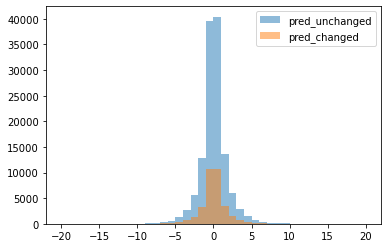

In [208]:
print("Average improvement in CE loss per document: DAda vs NAda")
print("pred changed:\t", overall_df[(overall_df.pred_rand != overall_df.pred_base)].ce_diff_base_rand.mean(),
      f"({overall_df[(overall_df.pred_rand != overall_df.pred_base)].shape[0]})")
print("pred unchanged:\t", overall_df[(overall_df.pred_rand == overall_df.pred_base)].ce_diff_base_rand.mean(),
     f"({overall_df[(overall_df.pred_rand == overall_df.pred_base)].shape[0]})")

print()

print("Average improvement in CE loss per document: TAda vs DAda")
print("pred changed:\t", overall_df[(overall_df.pred_rand != overall_df.pred_match)].ce_diff_rand_match.mean(),
     f"({overall_df[(overall_df.pred_rand != overall_df.pred_match)].shape[0]})")
print("pred unchanged:\t", overall_df[(overall_df.pred_rand == overall_df.pred_match)].ce_diff_rand_match.mean(),
     f"({overall_df[(overall_df.pred_rand == overall_df.pred_match)].shape[0]})")

bins = np.linspace(-20, 20, 41)
plt.hist(overall_df[(overall_df.pred_rand == overall_df.pred_match)].ce_diff_rand_match, bins=bins, alpha=0.5, label='pred_unchanged')
plt.hist(overall_df[(overall_df.pred_rand != overall_df.pred_match)].ce_diff_rand_match, bins=bins, alpha=0.5, label='pred_changed')
plt.legend(loc='upper right')
plt.show()

In [184]:
def did_pred_change(row, comp1, comp2):
    if row[f"pred_{comp1}"]!=row[f"pred_{comp2}"]:
        return 1
    else:
        return 0

overall_df["pred_change_base_rand"] = overall_df.apply(lambda x: did_pred_change(x, "base", "rand"), axis=1)
overall_df["pred_change_rand_match"] = overall_df.apply(lambda x: did_pred_change(x, "rand", "match"), axis=1)

display(spearmanr(overall_df[overall_df.ce_diff_base_rand.notna()].pred_change_base_rand, overall_df[overall_df.ce_diff_base_rand.notna()].ce_diff_base_rand))
display(spearmanr(overall_df[overall_df.ce_diff_rand_match.notna()].pred_change_rand_match, overall_df[overall_df.ce_diff_rand_match.notna()].ce_diff_rand_match))

print()

display(ttest_ind(overall_df[overall_df.ce_diff_base_rand.notna()].pred_change_base_rand, overall_df[overall_df.ce_diff_base_rand.notna()].ce_diff_base_rand))
display(ttest_ind(overall_df[overall_df.ce_diff_rand_match.notna()].pred_change_rand_match, overall_df[overall_df.ce_diff_rand_match.notna()].ce_diff_rand_match))

SpearmanrResult(correlation=-0.02035527415209116, pvalue=1.8165216430674298e-16)

SpearmanrResult(correlation=-0.0027274034002471447, pvalue=0.2699796366740861)

Ttest_indResult(statistic=-259.9590982779896, pvalue=0.0)

Ttest_indResult(statistic=34.77991792890214, pvalue=1.4958067470498062e-264)

### How do changes in CE loss map onto correct/incorrect predictions?

In [133]:
# BASE VS RAND

print("Average change in CE loss per document by classification outcomes")
# correct before and after
calc_df = overall_df[(overall_df.pred_base == overall_df.label) & (overall_df.pred_rand == overall_df.label)]
print("correct before and after: \t", calc_df.ce_diff_base_rand.mean(), f"({calc_df.shape[0]})")

# not correct before but after
calc_df = overall_df[(overall_df.pred_base != overall_df.label) & (overall_df.pred_rand == overall_df.label)]
print("not correct before but after: \t", calc_df.ce_diff_base_rand.mean(), f"({calc_df.shape[0]})")

# correct before but not after
calc_df = overall_df[(overall_df.pred_base == overall_df.label) & (overall_df.pred_rand != overall_df.label)]
print("correct before but not after: \t", calc_df.ce_diff_base_rand.mean(), f"({calc_df.shape[0]})")

# not correct before and after
calc_df = overall_df[(overall_df.pred_base != overall_df.label) & (overall_df.pred_rand != overall_df.label)]
print("not correct before and after: \t", calc_df.ce_diff_base_rand.mean(), f"({calc_df.shape[0]})")

Average change in CE loss per document by classification outcomes
correct before and after: 	 6.466235453968977 (66199)
not correct before but after: 	 6.032803801410472 (16302)
correct before but not after: 	 5.921558788190905 (15282)
not correct before and after: 	 5.725938965279575 (82217)


In [212]:
# DAda VS TAda

print("Average improvement in CE loss per document by classification outcome: TAda vs DAda")
# correct before and after
calc_df = overall_df[(overall_df.pred_rand == overall_df.label) & (overall_df.pred_match == overall_df.label)]
print("DAda correct, TAda correct: \t", calc_df.ce_diff_rand_match.mean(), f"({calc_df.shape[0]})")

# not correct before but after
calc_df = overall_df[(overall_df.pred_rand != overall_df.label) & (overall_df.pred_match == overall_df.label)]
print("DAda incorrect, TAda correct: \t", calc_df.ce_diff_rand_match.mean(), f"({calc_df.shape[0]})")

# correct before but not after
calc_df = overall_df[(overall_df.pred_rand == overall_df.label) & (overall_df.pred_match != overall_df.label)]
print("DAda correct, TAda incorrect: \t", calc_df.ce_diff_rand_match.mean(), f"({calc_df.shape[0]})")

# not correct before and after
calc_df = overall_df[(overall_df.pred_rand != overall_df.label) & (overall_df.pred_match != overall_df.label)]
print("DAda incorrect, TAda incorrect: ",calc_df.ce_diff_rand_match.mean(), f"({calc_df.shape[0]})")

Average improvement in CE loss per document by classification outcome: TAda vs DAda
DAda correct, TAda correct: 	 0.04686912630091707 (71153)
DAda incorrect, TAda correct: 	 0.049152170330321696 (11570)
DAda correct, TAda incorrect: 	 0.03586178956242669 (11348)
DAda incorrect, TAda incorrect:  0.05330882681430649 (85929)


# POS TAG

In [137]:
%%time

def count_tokens(tokens_pos, pos):
    counter = 0
    for elem in tokens_pos:
        if elem[1]==pos:
            counter+=1
    return counter
    
for pos in ["PROPN", "NOUN"]:
    overall_df[f"count_{pos}"]=overall_df.tokens_pos.apply(lambda x: count_tokens(x, pos))

In [213]:
# RAND VS MATCH

POS = "PROPN"

print(f"Average number of {POS} tokens per document by classification outcome:")
# correct before and after
calc_df = overall_df[(overall_df.pred_rand == overall_df.label) & (overall_df.pred_match == overall_df.label)]
print("DAda correct, TAda correct: \t", calc_df[f"count_{POS}"].mean(), f"({calc_df.shape[0]})")

# not correct before but after
calc_df = overall_df[(overall_df.pred_rand != overall_df.label) & (overall_df.pred_match == overall_df.label)]
print("DAda incorrect, TAda correct: \t", calc_df[f"count_{POS}"].mean(), f"({calc_df.shape[0]})")

# correct before but not after
calc_df = overall_df[(overall_df.pred_rand == overall_df.label) & (overall_df.pred_match != overall_df.label)]
print("DAda correct, TAda incorrect: \t", calc_df[f"count_{POS}"].mean(), f"({calc_df.shape[0]})")

# not correct before and after
calc_df = overall_df[(overall_df.pred_rand != overall_df.label) & (overall_df.pred_match != overall_df.label)]
print("DAda incorrect, TAda incorrect: ", calc_df[f"count_{POS}"].mean(), f"({calc_df.shape[0]})")

Average number of PROPN tokens per document by classification outcome:
DAda correct, TAda correct: 	 1.9236715247424565 (71153)
DAda incorrect, TAda correct: 	 1.8335350043215213 (11570)
DAda correct, TAda incorrect: 	 1.7706203736341206 (11348)
DAda incorrect, TAda incorrect:  1.6261332029931688 (85929)


In [214]:
# RAND VS MATCH

POS = "NOUN"

print(f"Average number of {POS} tokens per document by classification outcome:")
# correct before and after
calc_df = overall_df[(overall_df.pred_rand == overall_df.label) & (overall_df.pred_match == overall_df.label)]
print("DAda correct, TAda correct: \t", calc_df[f"count_{POS}"].mean(), f"({calc_df.shape[0]})")

# not correct before but after
calc_df = overall_df[(overall_df.pred_rand != overall_df.label) & (overall_df.pred_match == overall_df.label)]
print("DAda incorrect, TAda correct: \t", calc_df[f"count_{POS}"].mean(), f"({calc_df.shape[0]})")

# correct before but not after
calc_df = overall_df[(overall_df.pred_rand == overall_df.label) & (overall_df.pred_match != overall_df.label)]
print("DAda correct, TAda incorrect: \t", calc_df[f"count_{POS}"].mean(), f"({calc_df.shape[0]})")

# not correct before and after
calc_df = overall_df[(overall_df.pred_rand != overall_df.label) & (overall_df.pred_match != overall_df.label)]
print("DAda incorrect, TAda incorrect: ", calc_df[f"count_{POS}"].mean(), f"({calc_df.shape[0]})")

Average number of NOUN tokens per document by classification outcome:
DAda correct, TAda correct: 	 7.710623585793993 (71153)
DAda incorrect, TAda correct: 	 6.71495246326707 (11570)
DAda correct, TAda incorrect: 	 6.71933380331336 (11348)
DAda incorrect, TAda incorrect:  6.177681574322987 (85929)


In [215]:
def did_pred_improve(row, comp1, comp2):
    if (row[f"pred_{comp1}"]!=row.label) and (row[f"pred_{comp2}"]==row.label):
        return 1
    else:
        return 0

overall_df["pred_improve_rand_match"] = overall_df.apply(lambda x: did_pred_improve(x, "rand", "match"), axis=1)

display(spearmanr(overall_df.pred_improve_rand_match, overall_df.count_PROPN))
display(spearmanr(overall_df.pred_improve_rand_match, overall_df.count_NOUN))


SpearmanrResult(correlation=0.007728199338970447, pvalue=0.0010424081643512556)

SpearmanrResult(correlation=-0.0022543704159857124, pvalue=0.33884850016807333)

In [191]:
overall_df[(overall_df.pred_rand != overall_df.label) & (overall_df.pred_match == overall_df.label)].sample(10, random_state=123)

,text,tokens_pos,tokens_ner,label,ce_diff_base_rand,ce_diff_rand_match,pred_base,pred_rand,pred_match,source,count_PROPN,count_NOUN,pred_change_base_rand,pred_change_rand_match
139898,You didn't ask me on the fly- You asked within...,"[[[CLS], SPECIAL], [you, PRON], [didn, VERB], ...","[[[CLS], SPECIAL], [you, NO_ENT], [didn, NO_EN...",politics,18.104947,1.660358,Libertarian,Libertarian,politics,test_2019_06_5k,8,20,0,1
127928,"If a leftist tries to punch you, go ahead and ...","[[[CLS], SPECIAL], [if, SCONJ], [a, DET], [lef...","[[[CLS], SPECIAL], [if, NO_ENT], [a, NO_ENT], ...",Conservative,0.001286,-0.000785,Conservative,The_Donald,Conservative,test_2019_04_5k,0,0,1,1
111119,"sis, i just interpreted what they said ̄\\__(ツ...","[[[CLS], SPECIAL], [sis, INTJ], [,, PUNCT], [i...","[[[CLS], SPECIAL], [sis, NO_ENT], [,, NO_ENT],...",ChapoTrapHouse,7.755135,1.720819,ChapoTrapHouse,Conservative,ChapoTrapHouse,test_2019_01_5k,0,0,1,1
49479,"Ok, Kurt Bardella. Person I’ve literally never...","[[[CLS], SPECIAL], [ok, INTJ], [,, PUNCT], [ku...","[[[CLS], SPECIAL], [ok, NO_ENT], [,, NO_ENT], ...",politics,14.459710,1.227222,politics,Conservative,politics,test_2017_12_5k,3,3,1,1
32927,The LP made no comments about executive fiat a...,"[[[CLS], SPECIAL], [the, DET], [lp, PROPN], [m...","[[[CLS], SPECIAL], [the, NO_ENT], [lp, NO_ENT]...",Libertarian,6.951028,2.573160,Conservative,Conservative,Libertarian,test_2017_09_5k,1,8,0,1
63938,I like how I was being facetious about this ve...,"[[[CLS], SPECIAL], [i, PRON], [like, VERB], [h...","[[[CLS], SPECIAL], [i, NO_ENT], [like, NO_ENT]...",Conservative,2.371035,0.627148,The_Donald,The_Donald,Conservative,test_2018_03_5k,2,2,0,1
4047,"That okie doke all is fine, nothing to see her...","[[[CLS], SPECIAL], [that, DET], [ok, ADV], [##...","[[[CLS], SPECIAL], [that, NO_ENT], [ok, NO_ENT...",The_Donald,2.572371,2.056833,The_Donald,politics,The_Donald,test_2017_03_5k,5,5,1,1
95374,.... McCain was a republican...,"[[[CLS], SPECIAL], [., PUNCT], [., PUNCT], [.,...","[[[CLS], SPECIAL], [., NO_ENT], [., NO_ENT], [...",Conservative,-0.000001,-0.000044,Conservative,politics,Conservative,test_2018_10_5k,1,0,1,1
31967,"This should be added to the [""Good Guy Trump""]...","[[[CLS], SPECIAL], [this, DET], [should, AUX],...","[[[CLS], SPECIAL], [this, NO_ENT], [should, NO...",The_Donald,9.983545,0.095550,politics,politics,The_Donald,test_2017_09_5k,3,1,0,1
114167,“If you strike us down we will become more pow...,"[[[CLS], SPECIAL], [“, PUNCT], [if, SCONJ], [y...","[[[CLS], SPECIAL], [“, NO_ENT], [if, NO_ENT], ...",The_Donald,9.583201,0.815191,The_Donald,Libertarian,The_Donald,test_2019_01_5k,0,3,1,1


# PSP RESULTS

In [198]:
conf_base = confusion_matrix(overall_df.label, overall_df.pred_base)

In [199]:
conf_rand = confusion_matrix(overall_df.label, overall_df.pred_rand)

In [200]:
conf_match = confusion_matrix(overall_df.label, overall_df.pred_match)

In [201]:
conf_rand-conf_base

array([[  51,  177,   30, -276,   18],
       [-202,  589,   -2, -271, -114],
       [ -95,  189,  158, -251,   -1],
       [-189,  379,  -36, -152,   -2],
       [-231,  185,   33, -361,  374]])

In [202]:
conf_match - conf_rand

array([[  32,   47,   47,  -92,  -34],
       [  30,  170,  113, -227,  -86],
       [ -88, -102,  202,   27,  -39],
       [   4,    6,   67,  -81,    4],
       [  62,    9,   24,    6, -101]])

In [24]:
# load results to dict

MODEL_TYPE = "base+month"

id_to_label = {
    0: "ChapoTrapHouse",
    1: "Conservative",
    2: "Libertarian",
    3: "The_Donald",
    4: "politics"
}

results = {}
directory = f'../../0_results/classification/reddit/month-models/{MODEL_TYPE}'
for result_csv in os.listdir(directory):
    if result_csv.endswith(".csv") and "20k-test" in result_csv:
        results[os.path.splitext(result_csv)[0]] = pd.read_csv(os.path.join(directory, result_csv))
        for key in id_to_label:
            results[os.path.splitext(result_csv)[0]].prediction.replace(key, id_to_label[key], inplace=True)

In [25]:
# load monthly test sets to dict

test_sets = {}

directory = '../../0_data/clean/labelled_reddit/month_splits/'
for test_csv in os.listdir(directory):
    if test_csv.endswith("5k.csv") and "test" in test_csv:
        test_sets[os.path.splitext(test_csv)[0]] = pd.read_csv(os.path.join(directory, test_csv))

In [26]:
# merge predictions of month-tuned models to test sets
for test_month in sorted(test_sets):
    for model in sorted(results):
        if test_month in model:
            test_sets[test_month] = test_sets[test_month].merge(results[model]["prediction"],left_index=True, right_index=True)
            test_sets[test_month].rename(columns={"prediction": model}, inplace=True)

In [87]:
%%time

# find cases that are correct when tuning month = test month, then count number of correct predictions for that case from the 35 other month-tuned models

def count_correct(row, test_month):

    n_correct = 0

    for key in row.index:
        if key.startswith("bert-base") and f"train_{re.search('test_(.*?)_5k',test_month).group(1)}" not in key:
            if row.label == row[key]:
                n_correct+=1
            
    return n_correct

analysis_dict = {}

for test_month in sorted(test_sets):
    df = test_sets[test_month].copy()
    df = df[df.label==df[f"bert-base-train_{re.search('test_(.*?)_5k',test_month).group(1)}_20k-{test_month}"]]
    
    df["n_correct"]= df.apply(lambda x: count_correct(x, test_month), axis=1)
    
    analysis_dict[test_month] = df

CPU times: user 33.8 s, sys: 90.8 ms, total: 33.9 s
Wall time: 34 s


In [126]:
TOP_N = 5

for test_month in sorted(analysis_dict):
    print(test_month.upper(), "\n")
    output_df = analysis_dict[test_month].sort_values("n_correct").tail(TOP_N).copy()
    for index, row in output_df.iterrows():
        print(row.label.upper())
        print(row.clean_text, "\n")
    print()

TEST_2017_03_5K 

LIBERTARIAN
They're not irreconcilable. If there were irreconcilable then no business could ever exist - because all those people come together *freely* and freely trade. They all come out ahead - or they wouldn't cooperate. How can that be so hard to see. 

POLITICS
[Is the GOP's Healthcare Proposal Titled 'World's Greatest'?]([URL] It's not just Trump supporters who spread 'fake news'. It was even on the front page of reddit yesterday, and I saw it freshly posted again on facebook today. 

LIBERTARIAN
This is, on it's face, false. Of course taxation is bad and we should limit it to the extent we can. Who think taxes aren't bad? Otherwise why not just set taxes to 100% and hand over ownership of the economy to the government. After all taxes have no downside, amiright? Obviously the taxes themselves aren't good, but they can be spent on good things. No one would be in favor of taxes if the money were just burned in a pit. However, spending it on collective projects c

In [123]:
analysis_dict["test_2017_03_5k"].groupby("n_correct").clean_text.count()

n_correct
0      25
1      18
2      27
3      27
4      46
5      33
6      41
7      37
8      48
9      41
10     40
11     51
12     52
13     42
14     52
15     50
16     59
17     54
18     48
19     50
20     67
21     54
22     60
23     58
24     67
25     71
26     78
27     63
28     72
29     92
30     93
31    106
32     83
33    123
34    163
35    364
Name: clean_text, dtype: int64

test_2017_03_5k


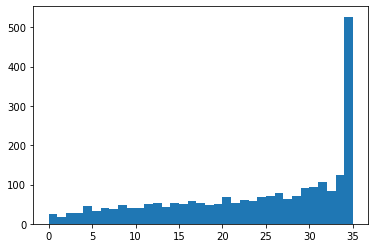


test_2017_04_5k


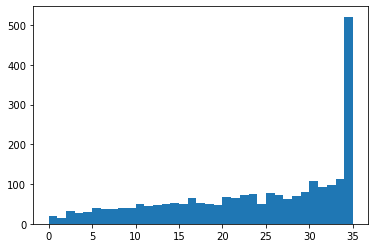


test_2017_05_5k


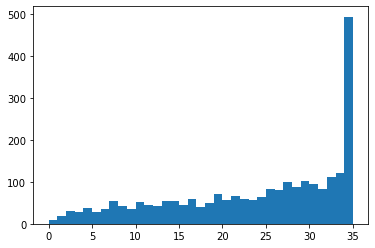


test_2017_06_5k


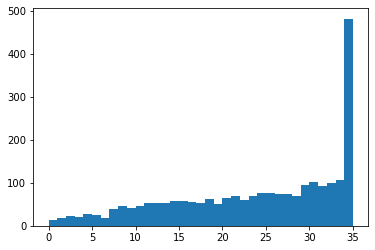


test_2017_07_5k


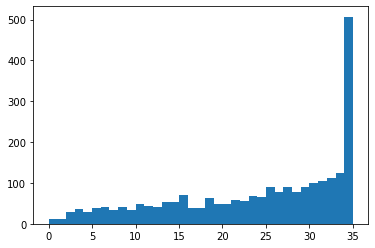


test_2017_08_5k


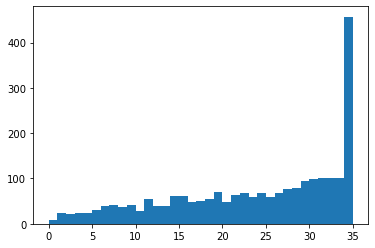


test_2017_09_5k


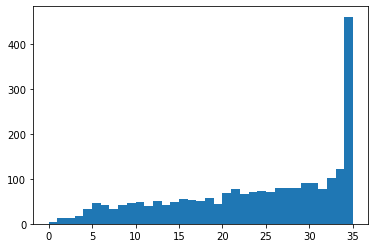


test_2017_10_5k


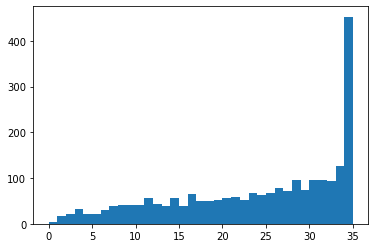


test_2017_11_5k


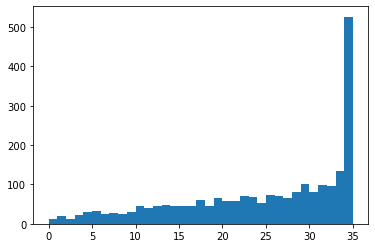


test_2017_12_5k


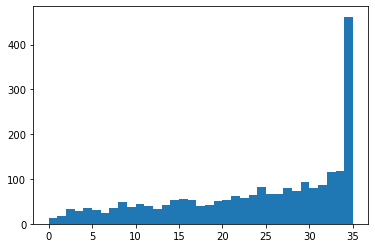


test_2018_01_5k


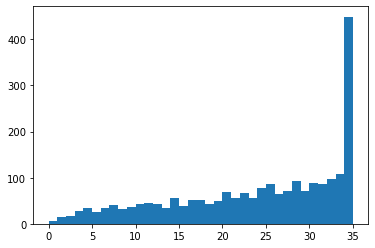


test_2018_02_5k


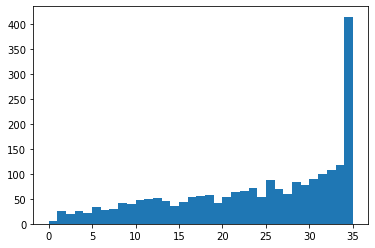


test_2018_03_5k


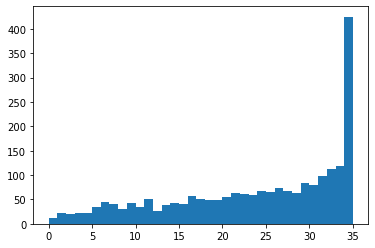


test_2018_04_5k


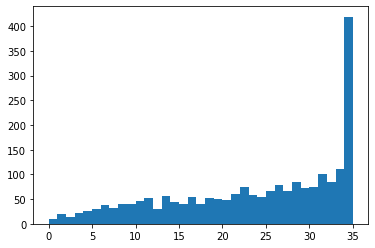


test_2018_05_5k


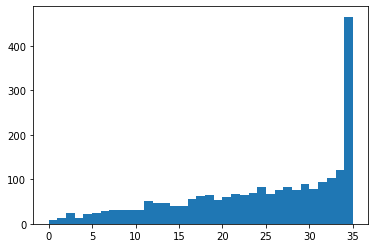


test_2018_06_5k


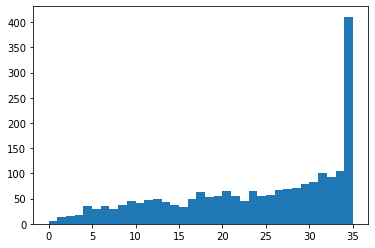


test_2018_07_5k


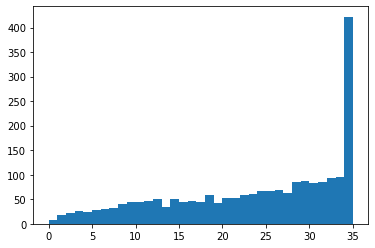


test_2018_08_5k


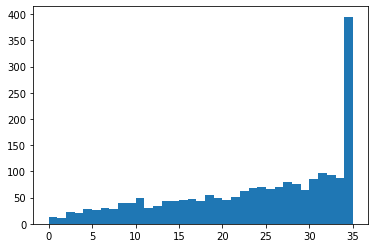


test_2018_09_5k


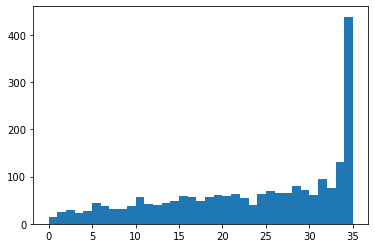


test_2018_10_5k


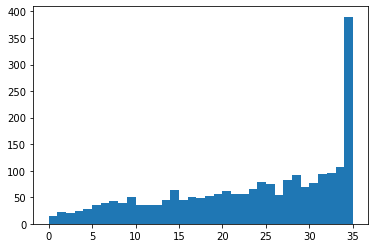


test_2018_11_5k


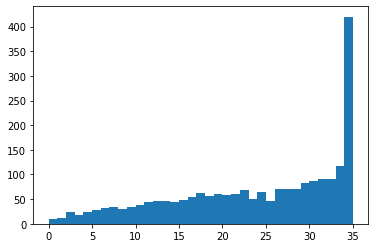


test_2018_12_5k


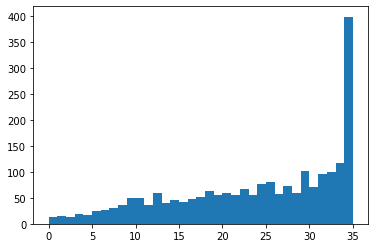


test_2019_01_5k


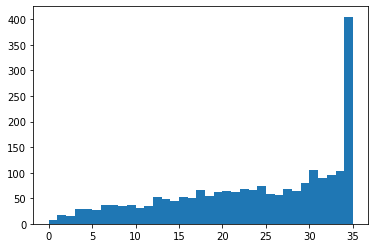


test_2019_02_5k


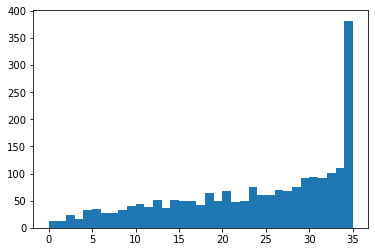


test_2019_03_5k


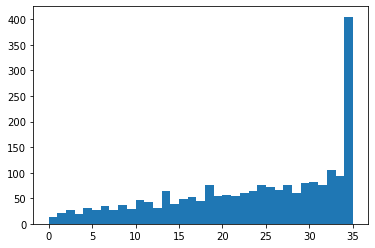


test_2019_04_5k


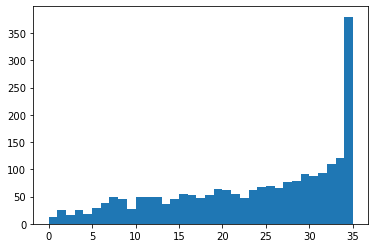


test_2019_05_5k


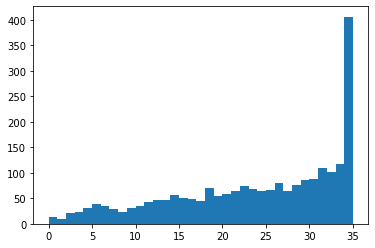


test_2019_06_5k


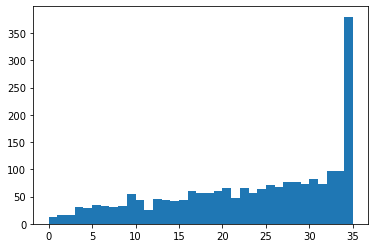


test_2019_07_5k


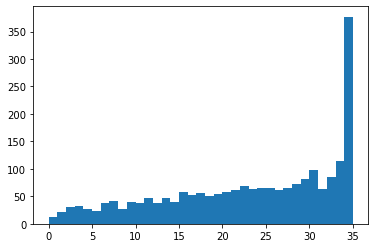


test_2019_08_5k


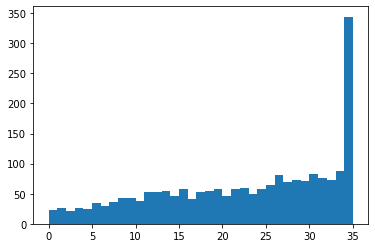


test_2019_09_5k


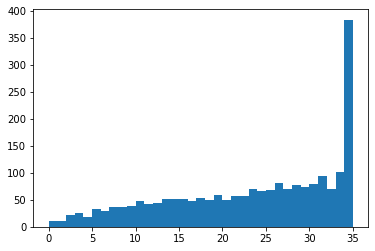


test_2019_10_5k


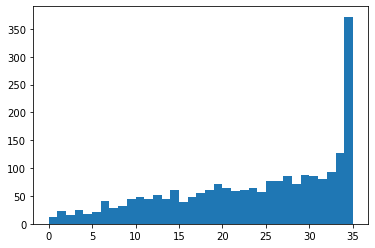


test_2019_11_5k


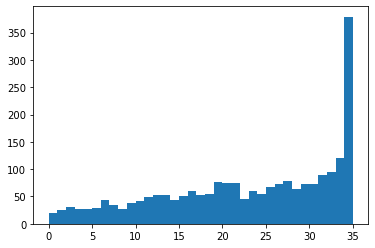


test_2019_12_5k


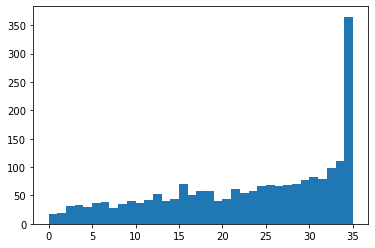


test_2020_01_5k


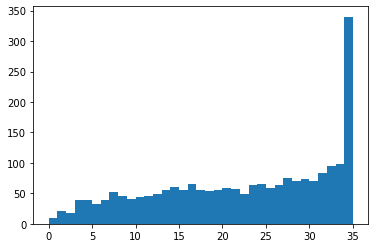


test_2020_02_5k


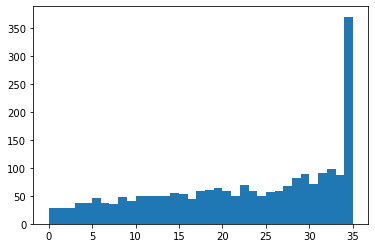

In [121]:
for test_month in sorted(analysis_dict):
    print(test_month)
    plt.hist(analysis_dict[test_month].n_correct, bins=35)
    plt.show()
    print()